# 6.2 ラプラス近似(Laplace approximation)
1. 勾配法によって、事後分布の極大値を1つ求め、近似用の正規分布の平均とする。
1. 求めた極大値において、､2階微分が一致するように近似用の正規分布の分散を求める。

In [1]:
# パッケージの読み込み
using Distributions, PyPlot, ForwardDiff, LinearAlgebra

In [2]:
# n次元単位行列
eye(n) = Diagonal{Float64}(I, n)

# パラメータ抽出用の関数
unzip(a) = map(x -> getfield.(a, x), fieldnames(eltype(a)))

unzip (generic function with 1 method)

In [3]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

## 6.2.3 ロジスティック回帰

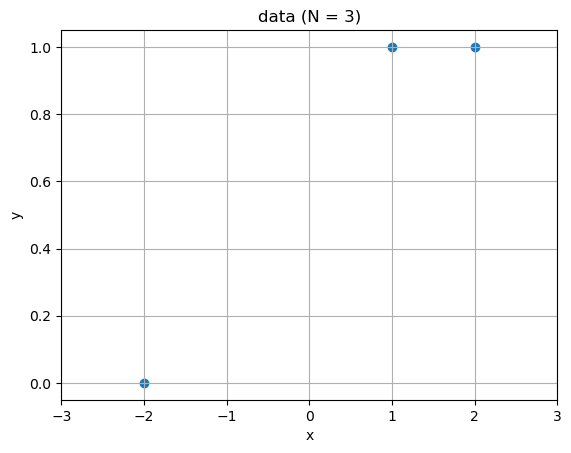

In [4]:
# 入力データ集合
X_obs = [-2, 1, 2]

# 出力データ集合
Y_obs = Bool.([0, 1, 1])

# 散布図で可視化
fig, ax = subplots()
ax.scatter(X_obs, Y_obs)
ax.set_xlim([-3,3])
set_options(ax, "x", "y", "data (N = $(length(X_obs)))")

In [5]:
# シグモイド関数
sig(x) = 1/(1 + exp(-x))

# 事前分布の設定
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0

10.0

In [6]:
# 対数同時分布
log_joint(w, X, Y, μ₁, σ₁, μ₂, σ₂) = logpdf(Normal(μ₁, σ₁), w[1]) +
                                     logpdf(Normal(μ₂, σ₂), w[2]) +
                                     sum(logpdf.(Bernoulli.(sig.(w[1]*X_obs .+ w[2])), Y_obs))
                                        
paras = (X_obs, Y_obs, μ₁, σ₁, μ₂, σ₂)

# 非正規化対数事後分布
ulp(w) = log_joint(w, paras...)

ulp (generic function with 1 method)

In [7]:
# 多変数解析のための勾配法
function gradient_method(f, x_init, η, maxiter)
    # 最適化過程のパラメータを格納する配列
    x_seq = Array{typeof(x_init[1]), 2}(undef, length(x_init), maxiter)
    
    # 勾配
    ∇f(x) = ForwardDiff.gradient(f, x)
    
    # 初期値
    x_seq[:, 1] = x_init
    
    # メインの最適化ループ
    for i in 2:maxiter
        x_seq[:, i] = x_seq[:, i-1] + η*∇f(x_seq[:, i-1])
    end
    
    x_seq
end

gradient_method (generic function with 1 method)

In [8]:
# 最適化のラッパー関数の定義
function inference_wrapper_gd(log_joint, paras, w_init, η, maxiter)
    ulp(w) = log_joint(w, paras...)
    w₁_seq = gradient_method(ulp, w_init, η, maxiter)
    w₁_seq
end

inference_wrapper_gd (generic function with 1 method)

In [9]:
# 最適化パラメータ
w_init = [0.0, 0.0]
maxiter = 2000
η = 0.1

# 最適化の実施
w_seq = inference_wrapper_gd(log_joint, paras, w_init, η, maxiter)
w_seq

2×2000 Matrix{Float64}:
 0.0  0.25  0.443351   0.596734  …  3.05148  3.05148  3.05148  3.05148
 0.0  0.05  0.0901561  0.123311     1.05601  1.05601  1.05601  1.05601

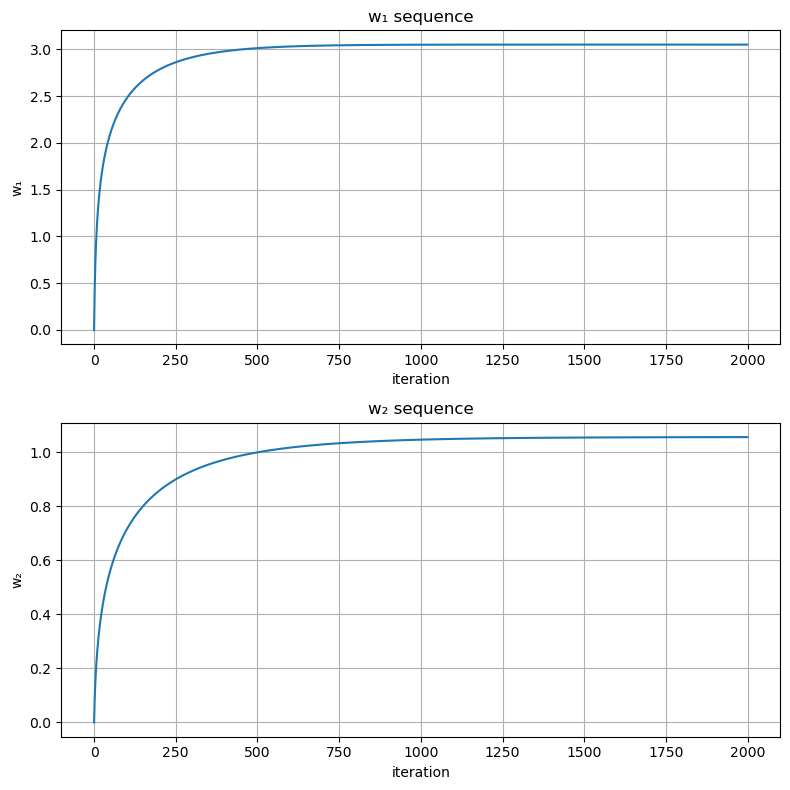

In [10]:
# 勾配法の過程を可視化
fig, axes = subplots(2,1,figsize=(8,8))
axes[1].plot(w_seq[1,:])
set_options(axes[1], "iteration", "w₁", "w₁ sequence")
axes[2].plot(w_seq[2,:])
set_options(axes[2], "iteration", "w₂", "w₂ sequence")

tight_layout()

In [11]:
# 平均
μ_approx = w_seq[:, end]

# 共分散
hessian(w) = ForwardDiff.hessian(ulp, w)
Σ_approx = inv(-hessian(μ_approx))

2×2 Matrix{Float64}:
 18.6137   -2.69261
 -2.69261  30.6517

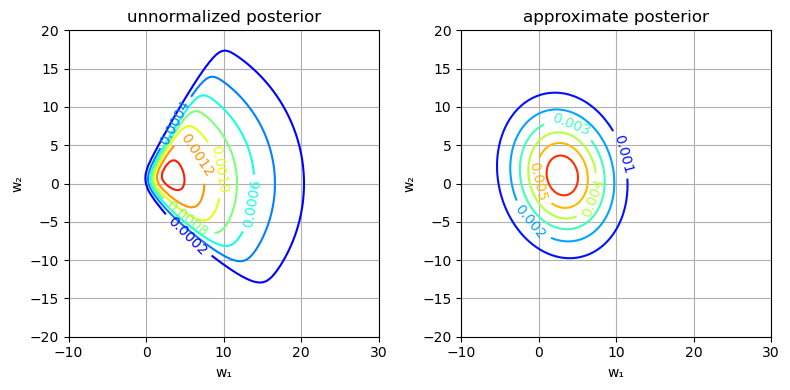

In [12]:
# 分布を可視化する範囲
w₁s = range(-10, 30, length=100)
w₂s = range(-20, 20, length=100)

fig, axes = subplots(1, 2, figsize=(8, 4))

# 非正規化事後分布の可視化
cs = axes[1].contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) + eps() for w₁ in w₁s, w₂ in w₂s]', cmap="jet")
axes[1].clabel(cs, inline=true)
set_options(axes[1], "w₁", "w₂", "unnormalized posterior")

# 近似正規分布の可視化
cs = axes[2].contour(w₁s, w₂s, [pdf(MvNormal(μ_approx, Σ_approx), [w₁, w₂]) for w₁ in w₁s, w₂ in w₂s]', cmap="jet")
axes[2].clabel(cs, inline=true)
set_options(axes[2], "w₁", "w₂", "approximate posterior")

tight_layout()

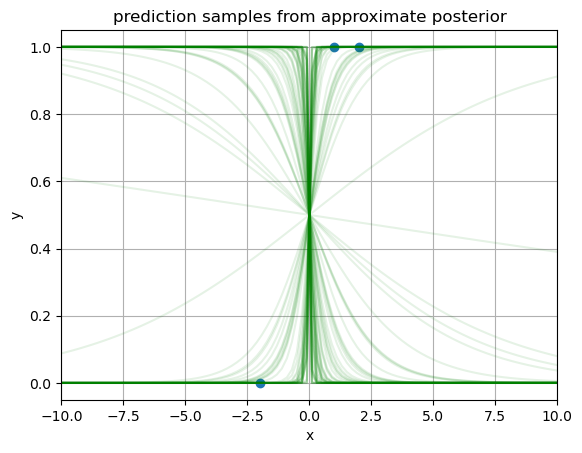

In [13]:
# 近似分布から候補のサンプルを100個抽出
W = rand(MvNormal(μ_approx, Σ_approx), 100)

xs = range(-10, 10, length=100)

fig, ax = subplots()
for i in 1:size(W,2)
    w₁, w₂ = W[:, i]
    f(x) = sig(w₁*x * w₂)
    ax.plot(xs, f.(xs), "g", alpha=0.1)
end

ax.scatter(X_obs, Y_obs)
ax.set_xlim(extrema(xs))
set_options(ax, "x", "y", "prediction samples from approximate posterior")

In [14]:
# 長方形の幅
Δ₁ = w₁s[2] - w₁s[1]
Δ₂ = w₂s[2] - w₂s[1]

# 積分近似による予測分布
p_predictive(x, y) = sum([pdf(Bernoulli(sig(w₁*x + w₂)), y) *
                           pdf(MvNormal(μ_approx, Σ_approx), [w₁, w₂]) *
                           Δ₁ * Δ₂ for w₁ in w₁s, w₂ in w₂s])

p_predictive (generic function with 1 method)

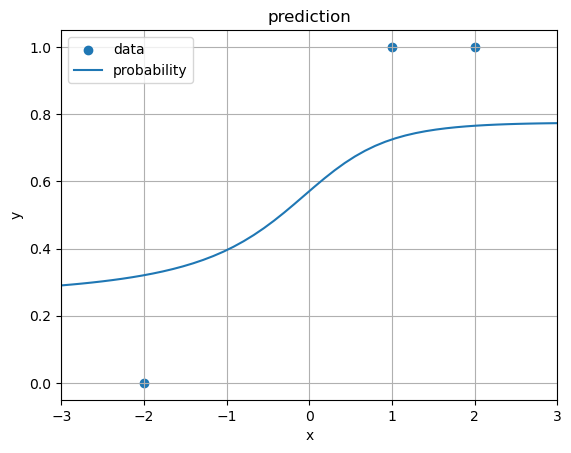

In [15]:
# 描画範囲
xs = range(-3, 3, length=50)

fig, ax = subplots()
ax.scatter(X_obs, Y_obs, label="data")
ax.plot(xs, p_predictive.(xs, 1), label="probability") 
ax.set_xlim([-3,3])
set_options(ax, "x", "y", "prediction", legend=true)